In [1]:
# TODO: add DPAMM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
import seaborn as sns
from math import sqrt
from numba import njit, float64
from numba.experimental import jitclass
from ing_theme_matplotlib import mpl_style

mpl_style(True)

In [2]:
@njit
def AM(a, b):
    """
    arithmetic mean
    """
    return (a + b) / 2


@njit
def GM(a, b):
    """
    geometric mean
    """
    return sqrt(a * b)

In [3]:
########################################
#              FMAMM class             #
########################################

FMAMM_spec = [("P", float64), ("L", float64), ("fee", float64)]


@jitclass(FMAMM_spec)
class FMAMM:
    def __init__(self, p=2500.0, l=10_000.0, f=0.0015):
        self.P = p
        self.L = l
        self.fee = f

    def xReserves(self):
        return self.L / sqrt(self.P)

    def yReserves(self):
        return self.L * sqrt(self.P)

    def tradeToPrice(self, extP):
        newP = self.P
        newL = self.L

        # price is high enough
        if extP * (1 - self.fee) / (1 + self.fee) > self.P:
            newP = sqrt(
                self.P * extP * (1 - self.fee) / (1 + self.fee)
            )  # optimal price for arbitrageur
            newL = self.L * AM(self.P, newP) / GM(self.P, newP)  # FMAMM logic
            +self.fee * self.L * (
                (sqrt(extP * (1 - self.fee) / (1 + self.fee)) - sqrt(self.P))
                / sqrt(newP)
            ) / 2  # fee

        # price is low enough
        elif extP * (1 + self.fee) / (1 - self.fee) < self.P:
            newP = sqrt(
                self.P * extP * (1 + self.fee) / (1 - self.fee)
            )  # optimal price for arbitrageur
            newL = self.L * AM(self.P, newP) / GM(self.P, newP)  # FMAMM logic
            +self.fee * self.L * sqrt(newP) * (
                1 / sqrt(extP * (1 + self.fee) / (1 - self.fee)) - 1 / sqrt(self.P)
            ) / 2  # fee

        # price is within nonprofitable range
        else:
            return (0, 0)

        # calculate the change in reserves
        delta_x = newL / sqrt(newP) - self.L / sqrt(self.P)
        delta_y = newL * sqrt(newP) - self.L * sqrt(self.P)

        # update state
        self.P = newP
        self.L = newL

        return (delta_x, delta_y)

In [4]:
########################################
#              CPMM class              #
########################################

CPMM_spec = [("P", float64), ("L", float64), ("fee", float64)]


@jitclass(CPMM_spec)
class CPMM:
    def __init__(self, p=2500.0, l=10_000.0, f=0.003):
        self.P = p
        self.L = l
        self.fee = f

    def xReserves(self):
        return self.L / sqrt(self.P)

    def yReserves(self):
        return self.L * sqrt(self.P)

    def tradeToPrice(self, extP):
        newP = self.P
        newL = self.L

        # price is high enough
        if extP * (1 - self.fee) > self.P:
            reportP = extP * (1 - self.fee)

            newL = self.L * sqrt(
                1 / (1 - self.fee) - self.fee / (1 - self.fee) * sqrt(self.P / reportP)
            )
            newP = reportP / (1 - self.fee) - self.fee / (1 - self.fee) * sqrt(
                self.P * reportP
            )

        # price is low enough
        if extP < self.P * (1 - self.fee):
            reportP = extP / (1 - self.fee)

            newL = self.L * sqrt(
                1 / (1 - self.fee) - self.fee / (1 - self.fee) * sqrt(reportP / self.P)
            )
            newP = (
                reportP
                * (1 - self.fee)
                * sqrt(self.P)
                / (sqrt(self.P) - self.fee * sqrt(reportP))
            )

        # price is within nonprofitable range
        else:
            return (0, 0)

        # calculate the change in reserves
        delta_x = newL / sqrt(newP) - self.L / sqrt(self.P)
        delta_y = newL * sqrt(newP) - self.L * sqrt(self.P)

        # update state
        self.P = newP
        self.L = newL

        return (delta_x, delta_y)

In [5]:
@njit
def run_simulations(
    daily_std,
    blocks_per_day,
    paths,
    days=1,
):
    # lvr for CPMM and FMAMM with 1 and 2 arbitrageurs, respectively
    results = np.zeros((4, paths))

    for jj in range(paths):
        amm0 = CPMM(10_000.0, 2500.0, 0.001)
        amm1 = FMAMM(10_000.0, 2500.0, 0.0005)

        # save the initial price
        p0 = amm0.P

        sigma = daily_std / np.sqrt(blocks_per_day)  # vol between blocks
        T = int(days * blocks_per_day)

        # Generate a GBM path for prices
        z = np.cumsum(np.random.normal(0.0, sigma, T))
        # Note that we are adding a risk-neutral drift, so that the price process is a martingale
        prices = np.exp(z - (np.arange(T) * sigma**2) / 2)
        prices = prices / prices[0] * p0

        lvr0 = 0.0
        lvr1 = 0.0

        for i in range(T):
            # CPMM
            val0 = 2 * amm0.L * sqrt(amm0.P)
            x0, y0 = amm0.tradeToPrice(prices[i])
            lvr0 += -(prices[i] * x0 + y0) / val0

            # FMAMM
            val1 = 2 * amm1.L * sqrt(amm1.P)
            x1, y1 = amm1.tradeToPrice(prices[i])
            lvr1 += -(prices[i] * x1 + y1) / val1

        results[:, jj] = [
            lvr0 / days,
            lvr1 / days,
            2 * amm0.L * sqrt(amm0.P),
            2 * amm1.L * sqrt(amm1.P),
        ]

    return results

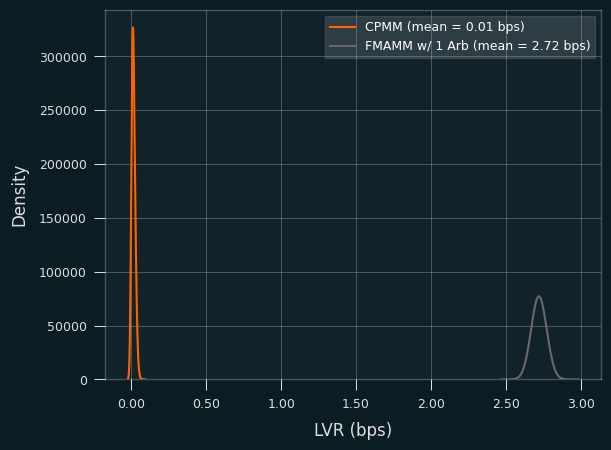

In [6]:
daily_std = 0.05
block_time = 12  # 12 for Mainnet, 5 for Gnosis, 1 for L2s
blocks_per_day = 24 * 60 * 60 / block_time
paths = 10_000
days = 7

results = run_simulations(daily_std, blocks_per_day, paths, days)

# sns.set_style("darkgrid")
# sns.set_palette("autumn")

bw_adjust = 5
means = np.mean(results, 1)

# Plotting with the specified adjustments
ax = sns.kdeplot(
    data=results[0, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[0] * 10**4:.2f} bps)",
)
ax = sns.kdeplot(
    data=results[1, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM w/ 1 Arb (mean = {means[1] * 10**4:.2f} bps)",
)

ax.set(xlabel="LVR (bps)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels(["{:.2f}".format(tick * 10000) for tick in ticks_loc])

plt.legend()
plt.show()

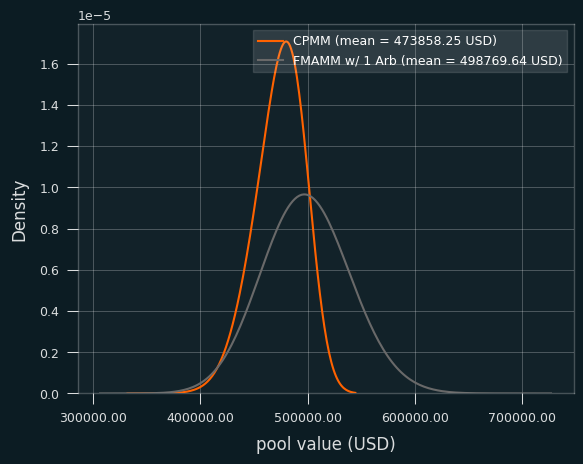

In [7]:
# Plotting with the specified adjustments
ax = sns.kdeplot(
    data=results[2, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[2]:.2f} USD)",
)
ax = sns.kdeplot(
    data=results[3, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM w/ 1 Arb (mean = {means[3]:.2f} USD)",
)

ax.set(xlabel="pool value (USD)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels(["{:.2f}".format(tick) for tick in ticks_loc])

plt.legend()
plt.show()